# 1. Hypothesis Generation 

- **Problem Statement: Build an ML Model that takes News Text as Input and Categorizes it into one of the following categories: sport, business, politics, entertainment, tech.**

- **Use-Case:** Multi-Class Text Classification Problem

- **Input Variables:**
    - 1. News Text (Text Field with average length of 2,500 characters) 
- **Output Variables:**
    - 1. News Category (sport, business, politics, entertainment, tech)
- **Applicable Word Transformations**:
    - 1. Bag of Words
    - 2. TF-IDF
    - 3. Word Vectorization Methods 
- **Applicable ML Algorithms:**
    - 1. Naive Bayes
    - 2. Logistic Regression
    - 3. Support Vector Machine (SVM)
    - 4. Random Forest
    - 5. Gradient Boosting
    - 6. Stochastic Gradient Descent (SGD) Classifier
    - 7. XGBoost

- **Applicable Evaluation Metrics:** 
    - Confusion Matrix:
        - Accuracy
        - Precision
        - Recall (Sensitivity)
        - F1 Score
    - Area Under the Receiver Operating Characteristic Curve (AUC-
    - Log Loss (Cross-Entropy) 
    - Hamming Loss

# 2. Import Libraries 

In [23]:
# Data handling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from collections import defaultdict

# data visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# machine learning model libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# model dumping libaries 
import joblib

# evaluation libraries
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, f1_score, hamming_loss
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss, precision_recall_fscore_support

import os 
import psycopg2
import re
import string
import time
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


# 3. Import Dataset 

In [61]:
df = pd.read_csv("data/BBC News Train.csv")
display(df)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [25]:
df.dtypes

ArticleId     int64
Text         object
Category     object
dtype: object

# 4. Exploratory Data Analysis - 1 

In [46]:
# Unique Values Counts for column 'Category' 
print('a) Number of Unique Values: ', df['Category'].nunique())
print('b) List and Count of Unique Values: ')
print(df['Category'].value_counts())
print('c) Normalized List and Count of Unique Values: ')
print(df['Category'].value_counts(normalize=True))


a) Number of Unique Values:  5
b) List and Count of Unique Values: 
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64
c) Normalized List and Count of Unique Values: 
Category
sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: proportion, dtype: float64


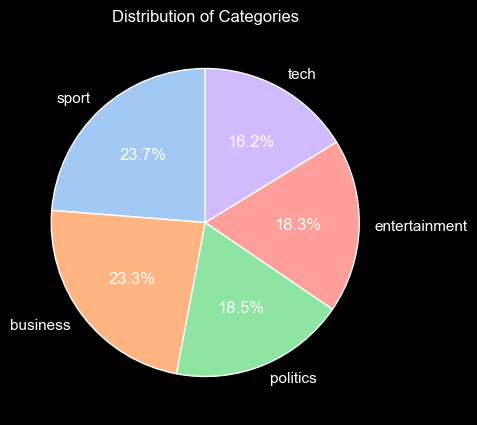

In [125]:
# Data Visualization for column 'Category'

# Count the occurrences of each category
category_counts = df['Category'].value_counts()

# Set the seaborn style with a black background
sns.set(style="darkgrid")

# Create a pie chart using seaborn
plt.figure(figsize=(5, 5), facecolor='black')  # Set the facecolor to black
plt.title('Distribution of Categories', color='white')  # Set the title color to white

# Customize the colors
colors = sns.color_palette('pastel')[0:len(category_counts)]

# Plot the pie chart with white label colors
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'color': 'white'})

# Display the plot
plt.show()


# 5. Data Preprocessing 

* __Remove Unnecessary Columns__
* __Handle Missing Values__
* __Handle Outliers__
* __Handle Errors/Noise__
* __Remove Duplicates__
* __Check Data Distribution and Skewness - Feature Scaling__

In [62]:
# remove unncessary columns
df = df[['Text', 'Category']]
df.head()

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business


In [63]:
# missing value handling 
print(df.shape) 
df.dropna(subset=["Text", "Category"], inplace=True) # Drop missing Values from the dataset, considering the mentioned columns 
print(df.shape)

(1490, 2)
(1490, 2)


In [64]:
# remove duplicates 
print(df.shape)

# print(df['Text'].value_counts())
df = df.drop_duplicates(subset = ["Text"], keep='last') 

print(df.shape)

(1490, 2)
(1440, 2)


In [65]:
# noise handling and cleaning 
print(df.shape) 
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove symbols and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]

    # Join the words back into a string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

df['CleanText'] = df['Text'].apply(preprocess_text)
print(df.shape)

(1440, 2)
(1440, 3)


# 6. Exploratory Data Analysis - 2 

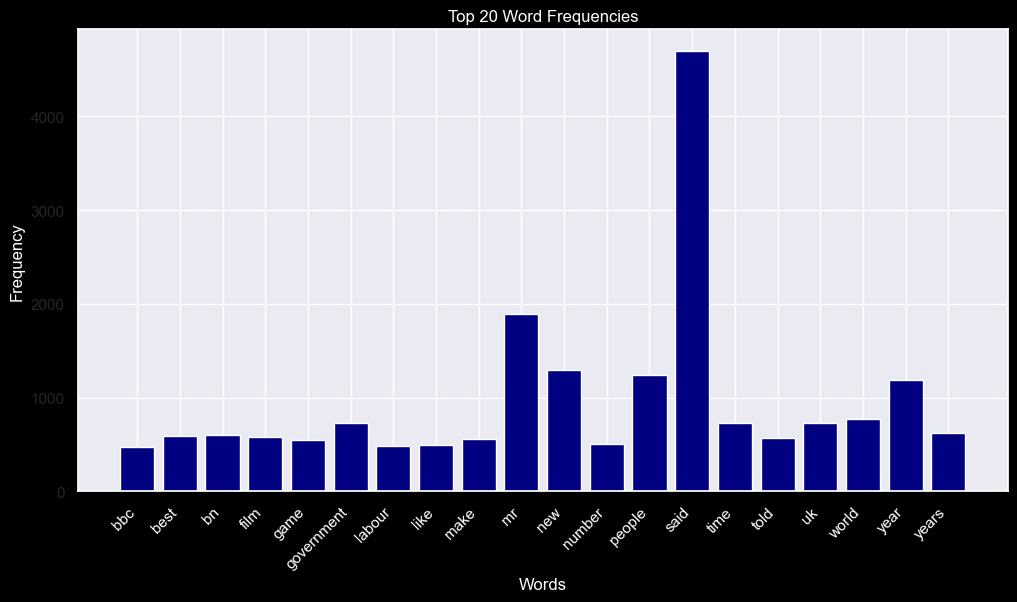

In [140]:
### Word Frequency Bar Graph Visualization ### 

# Create a CountVectorizer to get word frequencies
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_freq = vectorizer.fit_transform(df['CleanText'])

# Sum the word frequencies
word_freq_sum = word_freq.sum(axis=0)

# Get feature names (words)
features = vectorizer.get_feature_names_out()

# Set the seaborn style with a black background
sns.set(style="darkgrid")

# Define the color palette using seaborn with a navy blue color
navy_blue = sns.color_palette(["navy"])
navy_blue_palette = navy_blue * len(features)

# Plot the bar chart for word frequencies with navy blue color
plt.figure(figsize=(12, 6), facecolor='black')  # Set the facecolor to black
plt.bar(features, word_freq_sum.A1, color=navy_blue_palette)  # Use the navy blue color
plt.title('Top 20 Word Frequencies', color='white')  # Set the title color to white
plt.xlabel('Words', color='white')  # Set the xlabel color to white
plt.ylabel('Frequency', color='white')  # Set the ylabel color to white
plt.xticks(rotation=45, ha='right', color='white')  # Set the xticks color to white

# Display the plot
plt.show()


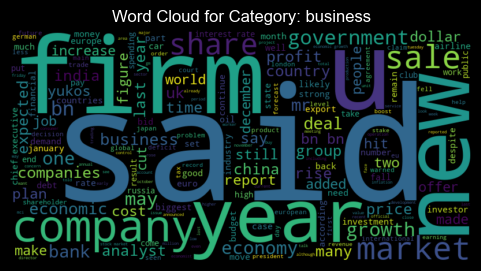

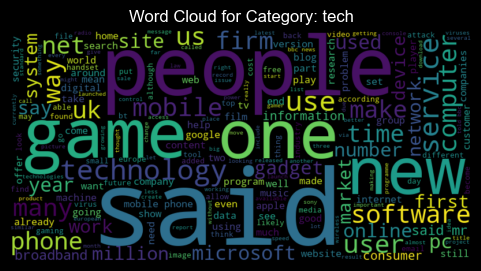

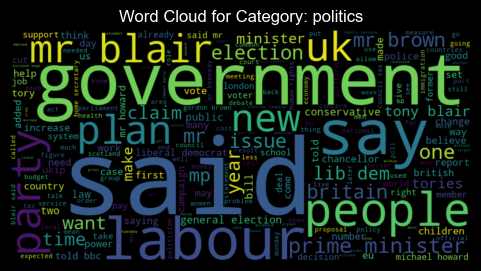

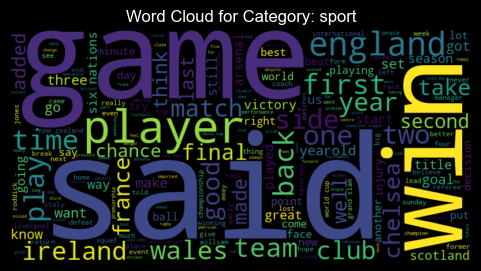

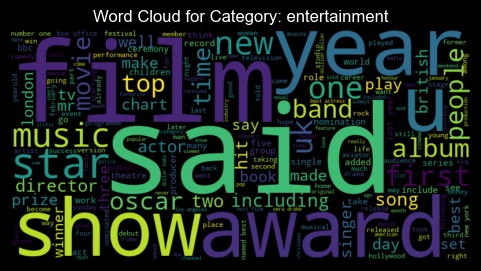

In [143]:
# Word Cloud Visualizations for each category 

# Create a dictionary to store text for each category
category_texts = defaultdict(str)

# Concatenate CleanText for each category
for category in df['Category'].unique():
    category_texts[category] = ' '.join(df[df['Category'] == category]['CleanText'])

# Create word clouds for each category
for category, text in category_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(text)
    
    plt.figure(figsize=(7, 3), facecolor='black')  # Set the facecolor to black
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}', color='white')  # Set the title color to white
    plt.axis('off')
    plt.show()


# 7. Dataset Splitting 

In [67]:
X = df['CleanText']
y = df['Category']

# Split the data into training and validation sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1152,)
(1152,)
(288,)
(288,)


# 8. Data Transformation (for NLP) 

In [68]:
# Use TF-IDF Embedding to produce word vectors for the column 'CleanText' 
text_embedding = TfidfVectorizer(max_features=5000)
X_train_embedded = text_embedding.fit_transform(X_train)
X_test_embedded = text_embedding.transform(X_test)

# Use Label Encoding for the column 'Category'
category_encoder = LabelEncoder()
y_train_encoded = category_encoder.fit_transform(y_train)
y_test_encoded = category_encoder.transform(y_test)


# 9. Model Selection and Fine-Tuning 

In [76]:
# Define a list of classifiers for iteration
classifiers = [
    ('Naive Bayes', MultinomialNB(), {}),
    ('Logistic Regression', LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10]}),
    ('SVM', OneVsRestClassifier(SVC()), {'estimator__C': [0.1, 1, 10], 'estimator__kernel': ['linear', 'rbf']}),
    ('Random Forest', RandomForestClassifier(), {'n_estimators': [50, 100, 200]}),
    ('Gradient Boosting', GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    ('SGD Classifier', SGDClassifier(), {'max_iter': [100, 200, 300], 'loss': ['hinge', 'log']}),
    ('XGBoost', XGBClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]})
]

best_model = None
best_score = 0.0

# Iterate through classifiers and perform hyperparameter tuning
for name, classifier, param_grid in classifiers:
    print(f"Training and tuning: {name}...")

    grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X_train_embedded, y_train_encoded)
    
    # Evaluate the model on the test set
    y_pred_encoded = grid_search.predict(X_test_embedded)
    accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
    f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')
    hamming = hamming_loss(y_test_encoded, y_pred_encoded)

    print(f"{name}: ")
    print(f"    Accuracy: {accuracy:.4f}\n    F1-Score: {f1:.4f}\n    Hamming Loss: {hamming:.4f}")
    print("____________________________________________________________________________________\n")
    
    # Keep track of the best model
    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search.best_estimator_

print("\nBest Model:")
print(best_model)


Training and tuning: Naive Bayes...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Naive Bayes: 
    Accuracy: 0.9514
    F1-Score: 0.9513
    Hamming Loss: 0.0486
____________________________________________________________________________________

Training and tuning: Logistic Regression...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic Regression: 
    Accuracy: 0.9549
    F1-Score: 0.9548
    Hamming Loss: 0.0451
____________________________________________________________________________________

Training and tuning: SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
SVM: 
    Accuracy: 0.9618
    F1-Score: 0.9619
    Hamming Loss: 0.0382
____________________________________________________________________________________

Training and tuning: Random Forest...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Random Forest: 
    Accuracy: 0.9340
    F1-Score: 0.9336
    Hamming Loss: 0.0660
________________________________

# 10. Model Finalization and Dumping 

In [144]:
X = df['CleanText']
y = df['Category']

# Use TF-IDF Embedding to produce word vectors for the column 'CleanText' 
text_embedding = TfidfVectorizer(max_features=5000)
X_embedded = text_embedding.fit_transform(X)

# Use Label Encoding for the column 'Category'
category_encoder = LabelEncoder()
y_encoded = category_encoder.fit_transform(y)


In [145]:
# Define the finalized model 
# model = SGDClassifier(loss='log', max_iter=300)
model = OneVsRestClassifier(estimator=SVC(C=1, kernel='linear'))
model.fit(X_embedded, y_encoded)

print("!!! Completed the Finalized Model Training on the entire dataset !!!")

!!! Completed the Finalized Model Training on the entire dataset !!!


In [146]:
# Save the trained model and related files 
dump_path = f"model_dump/"

joblib.dump(model, f"{dump_path}/model.joblib")
joblib.dump(text_embedding, f"{dump_path}/text_embedding.joblib")
joblib.dump(category_encoder, f"{dump_path}/category_encoder.joblib")

print("Model and related files are saved successfully !")

Model and related files are saved successfully !


# 11. Load Dumped Model for Real-time Testing 

In [148]:
# Load Unseen Test Data 
test_df = pd.read_csv("data/BBC News Test.csv") 
display(test_df)

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
5,51,lewsey puzzle over disallowed try england s jo...,sport
6,2025,blair blasts tory spending plans tony blair ha...,politics
7,1479,former ni minister scott dies former northern ...,politics
8,27,career honour for actor dicaprio actor leonard...,entertainment
9,397,tsunami to hit sri lanka banks sri lanka s b...,business


In [149]:
# drop missing value samples
test_df.dropna(subset=["Text", "Category"], inplace=True)

# Apply pre-processing 
test_df['CleanText'] = test_df['Text'].apply(preprocess_text)

# Load the saved model 
dump_path = f"model_dump/"
loaded_model = joblib.load(f"{dump_path}/model.joblib")
loaded_text_embedding = joblib.load(f"{dump_path}/text_embedding.joblib")
loaded_category_encoder = joblib.load(f"{dump_path}/category_encoder.joblib")

# Create a list to store predicted category values 
predicted_category = []

# Loop through the test dataframe and perform predictions for each row
for i, row in test_df.iterrows():
    # Prepare the new input for testing
    new_input_embedded = loaded_text_embedding.transform([row['CleanText']])
    # predicted_probs = loaded_model.predict_proba(new_input_embedded)
    predicted_probs = loaded_model.decision_function(new_input_embedded)
    predicted_labels = loaded_category_encoder.inverse_transform(predicted_probs.argmax(axis=1))

    # Append the predicted values to a list
    predicted_category.append(predicted_labels[0])

# Add the predicted category values as a new column in the DataFrame
test_df['PredictedCategory'] = predicted_category

In [150]:
display(test_df)

,ArticleId,Text,Category,CleanText,PredictedCategory
0,1018,qpr keeper day heads for preston queens park r...,sport,qpr keeper day heads preston queens park range...,sport
1,1319,software watching while you work software that...,tech,software watching work software monitor every ...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport,arcy injury adds ireland woe gordon arcy ruled...,sport
3,459,india s reliance family feud heats up the ongo...,business,india reliance family feud heats ongoing publi...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport,boro suffer morrison injury blow middlesbrough...,sport
5,51,lewsey puzzle over disallowed try england s jo...,sport,lewsey puzzle disallowed try england josh lews...,sport
6,2025,blair blasts tory spending plans tony blair ha...,politics,blair blasts tory spending plans tony blair la...,politics
7,1479,former ni minister scott dies former northern ...,politics,former ni minister scott dies former northern ...,politics
8,27,career honour for actor dicaprio actor leonard...,entertainment,career honour actor dicaprio actor leonardo di...,entertainment
9,397,tsunami to hit sri lanka banks sri lanka s b...,business,tsunami hit sri lanka banks sri lanka banks fa...,business


In [151]:
# Assuming test_df is your DataFrame with "Category" and "PredictedCategory" columns

# Evaluate accuracy
accuracy = accuracy_score(test_df['Category'], test_df['PredictedCategory'])
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(test_df['Category'], test_df['PredictedCategory']))

# Display confusion matrix
conf_matrix = confusion_matrix(test_df['Category'], test_df['PredictedCategory'])
print('\nConfusion Matrix:')
print(conf_matrix)


Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

     business       1.00      0.88      0.93         8
entertainment       1.00      1.00      1.00         4
     politics       0.83      1.00      0.91         5
        sport       1.00      1.00      1.00         9
         tech       1.00      1.00      1.00         4

     accuracy                           0.97        30
    macro avg       0.97      0.97      0.97        30
 weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
[[7 0 1 0 0]
 [0 4 0 0 0]
 [0 0 5 0 0]
 [0 0 0 9 0]
 [0 0 0 0 4]]


In [153]:
### Real-Time Testing on a Single Manual Sample ### 

manual_text = """OpenAI is at the forefront of artificial intelligence research, and one of their notable achievements is the development of 
Generative Pre-trained Transformers (GPTs). GPTs are advanced language models capable of understanding context, generating human-like text, 
and performing a wide range of natural language processing tasks. OpenAI's commitment to advancing the field of AI has led to the creation of 
several iterations of GPT, with each version showcasing remarkable improvements in language understanding and generation. GPT-3, the latest 
iteration, is particularly noteworthy for its ability to comprehend complex instructions, answer questions, and even create coherent and 
contextually relevant content. The impact of OpenAI's GPTs extends across various industries, from aiding in content creation to enhancing 
virtual assistants and contributing to cutting-edge research in natural language understanding."""

# Apply pre-processing
clean_text = preprocess_text(manual_text)

# Load the saved model
dump_path = f"model_dump/"
loaded_model = joblib.load(f"{dump_path}/model.joblib")
loaded_text_embedding = joblib.load(f"{dump_path}/text_embedding.joblib")
loaded_category_encoder = joblib.load(f"{dump_path}/category_encoder.joblib")

# Prepare the new input for testing
new_input_embedded = loaded_text_embedding.transform([clean_text])
# predicted_probs = loaded_model.predict_proba(new_input_embedded)
predicted_probs = loaded_model.decision_function(new_input_embedded)

# Apply softmax to normalize confidence scores to [0, 1]
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0)

# Get the predicted labels and confidence scores for all labels
predicted_labels = loaded_category_encoder.inverse_transform(predicted_probs.argmax(axis=1))
confidence_scores = {label: score for label, score in zip(loaded_category_encoder.classes_, predicted_probs.ravel())}
# Normalize confidence scores
normalized_confidence_scores = softmax(np.array(list(confidence_scores.values())))

# Display the results
print(f"Predicted Category: {predicted_labels[0]}\n")
print("Normalized Confidence Scores:")
for label, score in zip(confidence_scores.keys(), normalized_confidence_scores):
    print(f"{label}: {score:.4f}")


Predicted Category: tech

Normalized Confidence Scores:
business: 0.1845
entertainment: 0.1328
politics: 0.1520
sport: 0.1636
tech: 0.3671
